# Data Wrangling

## Imports

In [1]:
#Import the relevant modules
import os
import glob

import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt

import missingno as msno
from pathlib import Path

## Custom Functions

In [2]:
def get_file_name(file_name):
    name_ext = file_name.split("\\")[-1]
    name = name_ext.split(".")[0]
    return name

In [3]:
def count_missing(df):
    #Count the number of missing values .isnull() in each column well as the percentages 
    #Call pd.concat() to form a single table df with 'count' and '%' columns
    missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    missing.columns=['count', '%']
    missing = missing.loc[missing['count'] > 0]
    missing.sort_values(by='count', ascending = False)
    
    return missing

## Parameters

In [4]:
# Change directory one step back and save as the root directory
ROOT_DIR = os.path.normpath(os.getcwd() + os.sep + os.pardir)

#Define start and end dates
fromDate = '2000-01-01'
toDate = '2022-10-20'

## Read Dta

In [5]:
#Provide the name of CSV datasets
my_datasets_csv = [
    'eia_data_raw.csv',
    'fred_data_raw.csv',
    'offline_data_raw.csv']

In [6]:
# Change directory one step back and save as the root directory
ROOT_DIR = os.path.normpath(os.getcwd() + os.sep + os.pardir)

# Change direcotry to the 'data\interim' folder
path = ROOT_DIR + '\\data\\interim\\'

#Get the full file names (including directory)
for i in range(len(my_datasets_csv)):
    my_datasets_csv[i] = path + my_datasets_csv[i]

In [7]:
# Initialize list; this is the final list that will store all the data from the json pull. 
data = []

# loop over the list of csv files
for f in my_datasets_csv:
    #print file name
    print(get_file_name(f))
    
    #read the csv file into a new dataframe
    new_data = pd.read_csv(f)
    
    #drop the header
    new_data = new_data.drop(columns = ['Unnamed: 0'])
    
    #filter using from-to-dates
    new_data = new_data.loc[(new_data['Date'] >= fromDate) & (new_data['Date'] <= toDate)]
    
    #print the dataframe shape
    print(new_data.shape)

    data.append(new_data)

eia_data_raw
(274, 20)
fred_data_raw
(273, 8)
offline_data_raw
(274, 7)


## Merge dataframes

In [8]:
#find the df with longest dataseries
max_val = data[0].shape[0]
max_idx = 0

for i in range(len(data)):    
    size = size = data[i].shape[0]
    if size>max_val:
        max_val = size
        max_idx = i

In [9]:
#initiate the df with the the longest timeseries
df = data[max_idx]
for i in range(0, len(data)):
    if i != max_idx:
        df_temp = data[i]
        df = pd.merge_ordered(df, df_temp, on = 'Date')

df.set_index('Date', drop=True, inplace=True)

In [10]:
#sort data
df.sort_index(axis = 0, inplace = True)

## Explore features

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274 entries, 2000-01-01 to 2022-10-01
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   WTI_Price                             274 non-null    float64
 1   Oil_Production_OPEC                   274 non-null    float64
 2   Oil_Production_nonOPEC                274 non-null    float64
 3   Oil_Production_World                  270 non-null    float64
 4   Henry_Hub_NG_Price                    273 non-null    float64
 5   Oil_Production_US                     274 non-null    float64
 6   Petrol_Consumption_OECD               274 non-null    float64
 7   Petrol_Consumption_nonOECD            274 non-null    float64
 8   US_CPI                                274 non-null    float64
 9   US_PPI                                274 non-null    float64
 10  US_PPI_Petroleum                      274 non-null    float64
 11  US_PMI  

## Missing data

### Missing data statistics

In [12]:
#Count missing data
missing_stats = count_missing(df)
display(missing_stats)

,count,%
Oil_Production_World,4,1.459854
Henry_Hub_NG_Price,1,0.364964
Petroleum_Inventory_OECD,36,13.138686
Fed_Fund_Effective,1,0.364964
Index_Global_Real_Econ_Activity,2,0.729927
US_CPI_Energy,3,1.094891
EU19_PPI,4,1.459854
Real_Dollar_Index,73,26.642336
USD_EUR_Exchange,1,0.364964
Global_Econ_Policy_Uncertainty_Index,2,0.729927


### Missing data plot

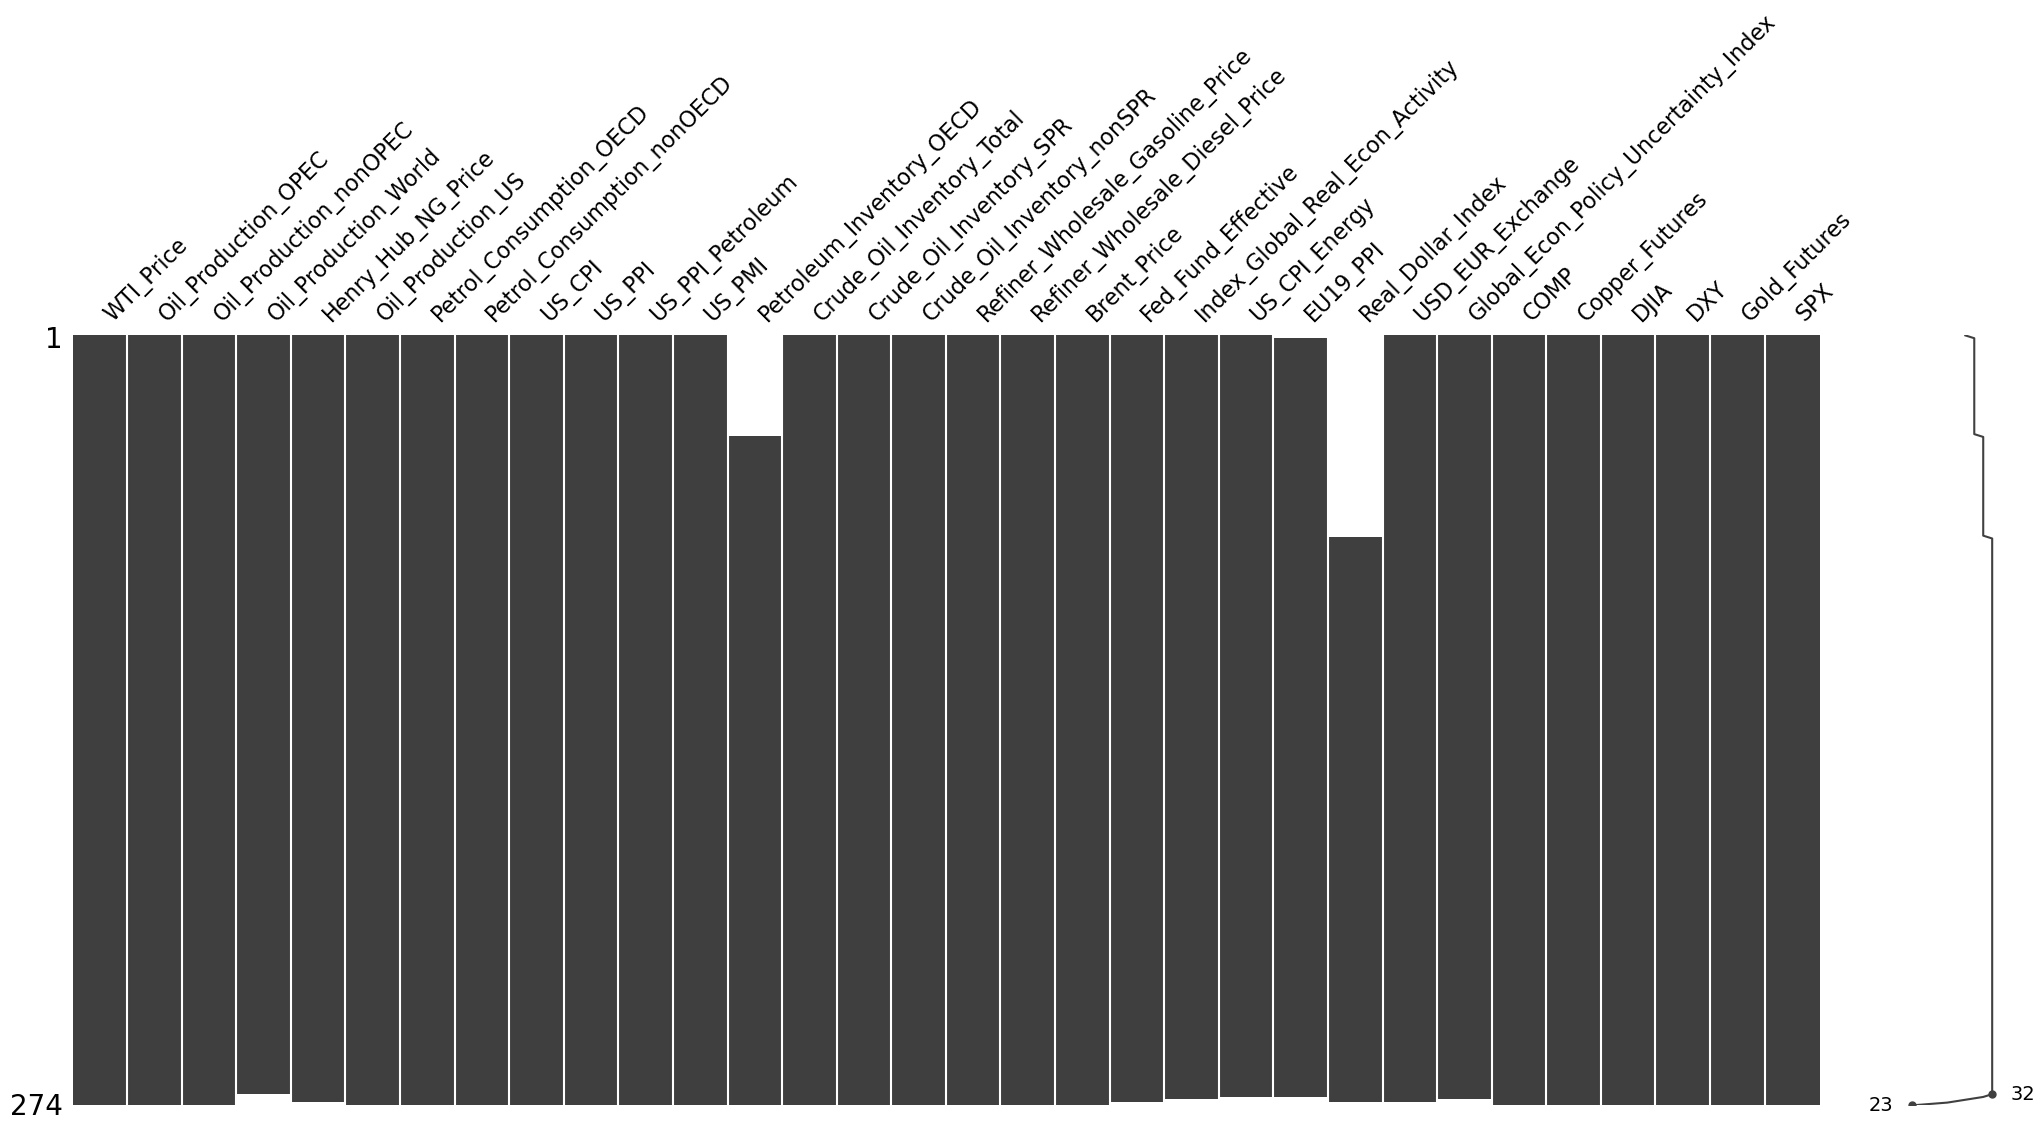

In [13]:
#Visualize the missing datausing "missingno" library
msno.matrix(df)
plt.show()

## Treat missing data

### Drop columns with NaN

It is recommended to drop the  other data sources for the following featuers with more that 10% missing

In [14]:
missing_10pct = missing_stats.loc[missing_stats['%'] > 10]
print(missing_10pct)

                          count          %
Petroleum_Inventory_OECD     36  13.138686
Real_Dollar_Index            73  26.642336


In [15]:
to_drop_columns = missing_10pct.index
dropped_col = df.drop(columns = to_drop_columns, inplace = False)

In [16]:
print('Original data:',df.shape)
print('Missing droppped:', dropped_col.shape)

Original data: (274, 32)
Missing droppped: (274, 30)


### Drop rows with NaN

In [17]:
dropped_row = dropped_col.dropna(axis = 0, inplace = False)

In [18]:
print('Missing droppped:', dropped_row.shape)

Missing droppped: (269, 30)


### Use df with no NaNs

In [19]:
df = dropped_row

## Explore data

### Check final DataFrame

In [25]:
#Display head of df
display(df.head().T)

Date,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01
WTI_Price,29.366000,29.842000,25.722000,28.788000,31.822000
Oil_Production_OPEC,26.675516,26.608782,27.516678,28.048591,27.639380
Oil_Production_nonOPEC,46.822508,46.937266,46.618731,46.623961,46.778141
Oil_Production_World,74470.542507,74439.049968,75116.129376,75639.562523,75360.217843
Henry_Hub_NG_Price,2.660000,2.790000,3.040000,3.590000,4.290000
Oil_Production_US,5.851839,5.918207,5.854166,5.846510,5.822882
Petrol_Consumption_OECD,50.229341,49.358083,46.286749,47.338795,47.955820
Petrol_Consumption_nonOECD,28.770679,28.528547,28.131882,28.216862,28.270995
US_CPI,1.700000,1.710000,1.709000,1.712000,1.722000
US_PPI,1.299187,1.305372,1.311693,1.317793,1.323801


In [21]:
#print columns of dataframe
i = 0
for item in df.columns:
    print (i, ": ", item)
    i += 1

0 :  WTI_Price
1 :  Oil_Production_OPEC
2 :  Oil_Production_nonOPEC
3 :  Oil_Production_World
4 :  Henry_Hub_NG_Price
5 :  Oil_Production_US
6 :  Petrol_Consumption_OECD
7 :  Petrol_Consumption_nonOECD
8 :  US_CPI
9 :  US_PPI
10 :  US_PPI_Petroleum
11 :  US_PMI
12 :  Crude_Oil_Inventory_Total
13 :  Crude_Oil_Inventory_SPR
14 :  Crude_Oil_Inventory_nonSPR
15 :  Refiner_Wholesale_Gasoline_Price
16 :  Refiner_Wholesale_Diesel_Price
17 :  Brent_Price
18 :  Fed_Fund_Effective
19 :  Index_Global_Real_Econ_Activity
20 :  US_CPI_Energy
21 :  EU19_PPI
22 :  USD_EUR_Exchange
23 :  Global_Econ_Policy_Uncertainty_Index
24 :  COMP
25 :  Copper_Futures
26 :  DJIA
27 :  DXY
28 :  Gold_Futures
29 :  SPX


### Traget feature

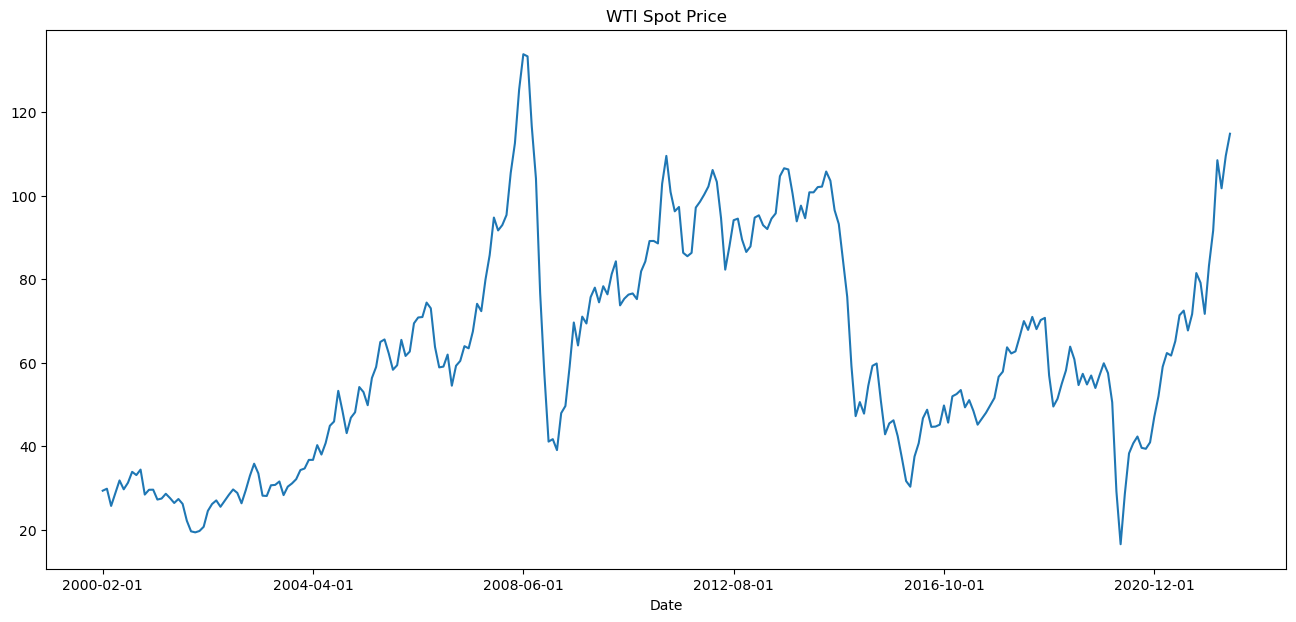

In [22]:
#Display the target feature
plt.figure(figsize = (16,7))
df['WTI_Price'].plot()
plt.title('WTI Spot Price')
plt.xlabel('Date')
plt.show()

### Histograms

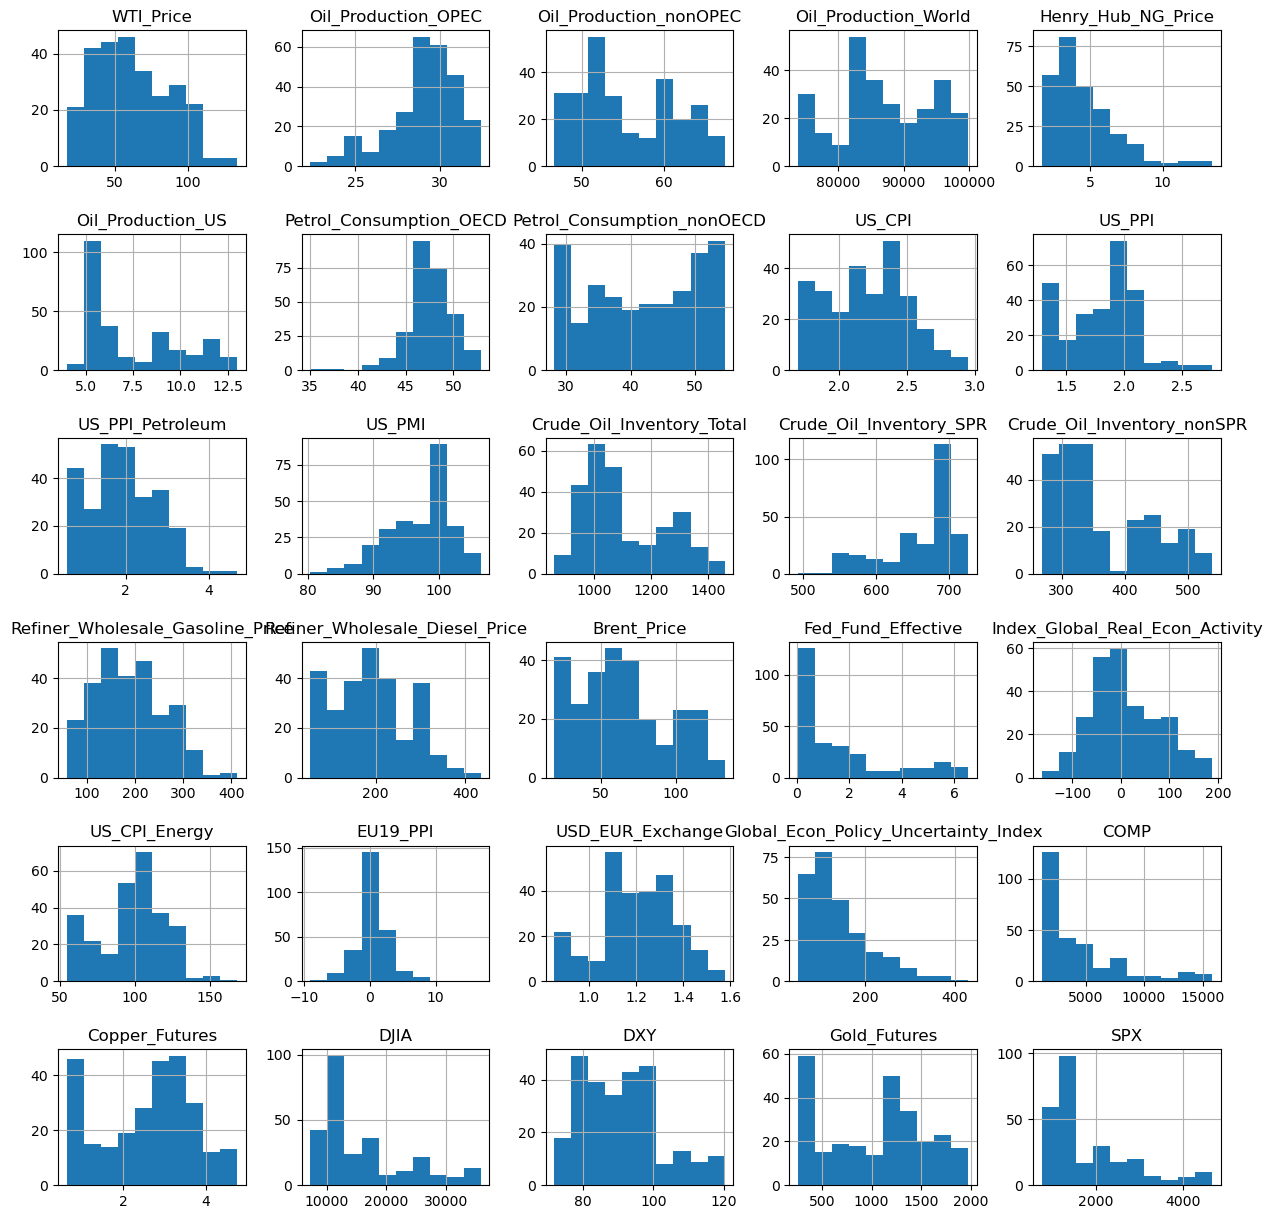

In [23]:
#Plot histogram of all  features
#Call plt.subplots_adjust() with an argument hspace=0.5 to adjust the spacing
#It's important you create legible and easy-to-read plots
df.hist(figsize=(15,15))
plt.subplots_adjust(hspace=0.5);


## Store data

In [24]:
# Change direcotry to the 'data\raw' folder
path = ROOT_DIR + '\\data\\interim\\'

# Set a file name
file_save = path + 'merged_eia_fred_offile.csv'
df.to_csv(file_save)

print('Save:\n', file_save)

Save:
 D:\gitProjects\springboard_capstone_1\Springboard_Capstone_01\data\interim\merged_eia_fred_offile.csv
